In [1]:
import numpy as np
import astropy as ap
import scipy as sp
from scipy import stats
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import csv

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Constants and other setup variables. Event rates are events/year. Spherical points should be (theta, phi)
low_energy_rate = 50
high_energy_rate = 70
low_energy_resolution = .5*np.pi/180
high_energy_resolution = .3*np.pi/180
lisa_resolution = 1*np.pi/180
NSIDE = 128
Npix = hp.nside2npix(NSIDE)

In [86]:
low_energy_map = np.zeros(Npix) + low_energy_resolution + np.random.rand(Npix)
high_energy_map = np.zeros(Npix) + high_energy_resolution + np.random.rand(Npix)

In [4]:
# Monte Carlo values
# time_vals = [10, 1000, 10000, 100000, 1000000]
# emri_array = [1, 100, 1000, 4000]
# mbh_array = [1,2,3]
# position_array = [1,2,3,4,5]

In [5]:
# Sample MC values
time_vals = [500000]
emri_array = [5000]
mbh_array = [50]
position_array = [1]

In [6]:
time_diff = 100000
# time_diff = 500
mbh_rate = 3
emri_rate = 500
position_factor = 1

In [7]:
def Ang2Vec(theta,phi):
    return np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])

In [8]:
def add_time(count):
    msec_in_year = 60*60*24*365*1000
    time = np.random.randint(msec_in_year, size=count)
    return time

In [9]:
# Get a random point on a sphere (uniform distribution). LISA should be fairly uniform and so should IceCube Gen II
def random_point(count):
    phi = np.random.random(count)*2*np.pi
    costheta = np.random.random(count)*2 - 1
    theta = np.arccos(costheta)
    return np.array([theta, phi]).T

In [10]:
def plot_gaussian_event(etheta, ephi, sigma, amp):
    theta,phi=hp.pix2ang(NSIDE,np.arange(Npix))
    return amp*np.exp(-((phi - ephi)**2+(theta - etheta)**2)/(2*sigma**2))

In [11]:
def healpix_smooth(etheta, ephi, sig, amp):
    pind = hp.ang2pix(NSIDE, etheta, ephi)
    temp = np.zeros(Npix)
    temp[pind] = amp
    return hp.smoothing(temp, sigma=sig)

In [74]:
def lisa_noise(count):
    return np.random.normal(size=count)*np.array(lisa_resolution)

In [70]:
# category = 0 --> low energy, 1 --> high energy
def hen_noise(positions, category):
    count = len(positions)
    pixinds = hp.ang2pix(NSIDE, positions[:,0], positions[:,1])
    if category == 0:
        noise_means = low_energy_map[pixinds]
    else:
        noise_means = high_energy_map[pixinds]
    return np.random.normal(size=count)*noise_means

In [71]:
# Reduce redundancy! hen=True --> HEN events, hen=False --> GW events
# category depends on hen. hen=True: category = 0 --> low energy, 1 --> high energy
# hen=False, category = 0 --> EMRI, 1 --> MBH (doesn't matter for now)
def general_noise(count, hen, category, points=0):
    if hen:
        noise_val = hen_noise(points, category)
    else:
        noise_val = lisa_noise(count)
    return noise_val

In [72]:
def general_event(poisson_lambda, hen, category):
    k = np.random.poisson(lam=poisson_lambda)
    points = random_point(k)
    noise = general_noise(k, hen, category, points).T
    time = add_time(k)
    return [points, noise, time]

In [14]:
def make_hp_map(points, noise):
    temp_map = np.zeros(Npix)
    for i,v in enumerate(points):
        temp_map += healpix_smooth(*v, noise[i], 1)
    return temp_map

In [15]:
def position_overlap(p1, p2, n1, n2):
    pvec1 = hp.ang2vec(*p1)
    pvec2 = hp.ang2vec(*p2)
    p1_disk = hp.query_disc(256, pvec1, n1*position_factor, inclusive=True)
    p2_disk = hp.query_disc(256, pvec2, n2*position_factor, inclusive=True)
    overlap = np.intersect1d(p1_disk, p2_disk)
    return len(overlap)

In [16]:
def position_coincident(p1, p2, n1, n2):
    pvec1 = Ang2Vec(*p1)
    pvec2 = Ang2Vec(*p2)
    dist = np.linalg.norm(pvec1 - pvec2)
    if dist < (n1 + n2)*position_factor:
        return True
    else:
        return False

In [17]:
def time_coincident(t1, t2):
    d = {}
    for i,v in enumerate(t1):
        h = np.abs(v - t2)
        a = np.where(h <= time_diff)[0]
        if a.shape[0] > 0:
            d[i] = a
    return d

In [18]:
def overlap(e1, n1, t1, e2, n2, t2, number=True):
    time_worthy = time_coincident(t1, t2)
    overlap_counter = 0
    pairs_overlap = []
    noise_overlap = []
    for i,v in enumerate(time_worthy):
        pos_1 = e1[v]
        noise_1 = np.linalg.norm(n1[v])
        for k in time_worthy[v]:
            pos_2 = e2[k]
            noise_2 = np.linalg.norm(n2[k])
            l = position_coincident(pos_1, pos_2, noise_1, noise_2)
            if l:
                if not number:
                    pairs_overlap.append([pos_1,pos_2])
                    noise_overlap.append([noise_1, noise_2])
                overlap_counter += 1
    
    return overlap_counter, pairs_overlap, noise_overlap

In [19]:
def monte_carlo_run(number):
    low = general_event(low_energy_rate, True, 0)
    high = general_event(high_energy_rate, True, 1)
    emri = general_event(emri_rate, False, 0)
    mbh = general_event(mbh_rate, False, 1)
    l_e, le_p, le_n = overlap(*low, *emri, number)
    l_m, lm_p, lm_n = overlap(*low, *mbh, number)
    h_e, he_p, he_n = overlap(*high, *emri, number)
    h_m, hm_p, hm_n = overlap(*high, *mbh, number)
    
    return np.array([l_e, l_m, h_e, h_m]), np.array([le_p,lm_p,he_p,hm_p]), np.array([le_n, lm_n, he_n, hm_n])

In [20]:
def mc_big_hammer(number, n=100, make_arrays=False, make_plots=False):
    global time_diff
    global emri_rate
    global mbh_rate
    global position_factor
    with open('output/monte_run.csv', 'w') as csvfile:
        a = csv.writer(csvfile)
        header = ['n', 'time_diff', 'position_factor', 'emri', 'mbh', 'total_coincident']
        a.writerow(header)
    with open('output/total_run.csv', 'w') as csvfile:
        b = csv.writer(csvfile)
        header = ['n', 'time_diff', 'position_factor', 'emri', 'mbh', 'total_coincident']
        b.writerow(header)
    for i in time_vals:
        time_diff = i
        for j in emri_array:
            emri_rate = j
            for k in mbh_array:
                mbh_rate = k
                for l in position_array:
                    lval=[]
                    position_factor = l
                    for m in tqdm(range(n)):
                        monte_data,points,noise = monte_carlo_run(number)
                        total = np.sum(monte_data)
                        lval.append(total)
                        monte_name = 'monte_big_time%i_emri%i_mbh%i_pos%i_%i_' % (i, j, k, l, m)
                        if make_arrays:
                            np.save('output/' + monte_name, monte_data)
                        if total > 0 and make_plots:
                            big_map = np.zeros(Npix)
                            for map_index in range(len(points)):
                                temp_map = np.zeros(Npix)
                                if monte_data[map_index] == 0:
                                    continue
                                noises = []
                                pointses = []
                                for pair_ind in range(len(noise[map_index])):
                                    noises += noise[map_index][pair_ind]
                                    pointses += points[map_index][pair_ind]
                                temp_map += make_hp_map(pointses, noises)
                                big_map += temp_map
                                
                                np.save('maps/'+monte_name+'map_'+str(map_index),temp_map)
                                hp.mollview(temp_map)
                                plt.savefig('maps/'+monte_name+'mollview_'+str(map_index))
                                plt.close()
                            hp.mollview(big_map)
                            plt.savefig('maps/'+monte_name+'mollview')
                            plt.close()
                        with open('output/monte_run.csv', 'a') as csvfile:
                            c = csv.writer(csvfile)
                            data = [m,i,l,j,k,total]
                            c.writerow(data)
                    run_total = np.sum(lval)
                    with open('output/total_run.csv', 'a') as csvfile:
                        d = csv.writer(csvfile)
                        data = [n,i,l,j,k,run_total]
                        d.writerow(data)
                    if make_arrays:
                        array_name = 'lval_big_time%i_emri%i_mbh%i_pos%i_%i_' % (i, j, k, l, n)
                        np.save('output/' + array_name, lval)
                    if make_plots:
                        plt.hist(lval);
                        plt.savefig('images/' + array_name)
                        plt.close()

In [21]:
def mc(number, n=100):
    lval = []
    for i in tqdm(range(n)):
        k, _, _ = monte_carlo_run(number)
        lval.append(k)
    return lval

In [80]:
n = 1000
m = np.array(mc(False, n))

<BarContainer object of 4 artists>

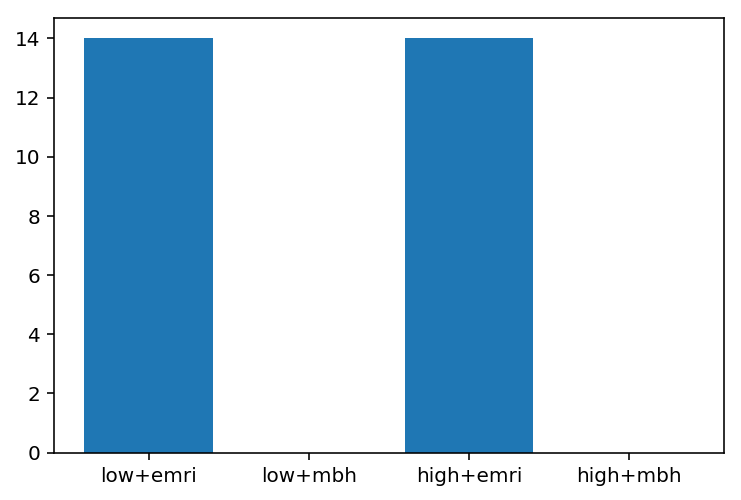

In [89]:
plt.bar(["low+emri", "low+mbh", "high+emri", "high+mbh"], np.sum(m, axis=0))

In [85]:
%timeit general_event(low_energy_rate, True, 0)

29 µs ± 247 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [86]:
low = general_event(low_energy_rate, True, 0)
emri = general_event(emri_rate, False, 0)
l_e, le_p, le_n = overlap(*low, *emri)

In [89]:
%timeit new_overlap(*low, *emri)

252 µs ± 5.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [88]:
def new_overlap(e1, n1, t1, e2, n2, t2):
    if len(e1) > len(e2):
        time_worthy = time_coincident(t2, t1)
    else:
        time_worthy = time_coincident(t1, t2)
    
    overlap_counter = 0
    for i,v in enumerate(time_worthy):
        pos_1 = e1[v]
        noise_1 = np.linalg.norm(n1[v])
        for k in time_worthy[v]:
            pos_2 = e2[k]
            noise_2 = np.linalg.norm(n2[k])
            l = position_coincident(pos_1, pos_2, noise_1, noise_2)
            if l:
                overlap_counter += 1
    return overlap_counter

In [334]:
%timeit new_overlap(*emri, *low)

2.23 ms ± 43.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [304]:
def fast_time(t1, t2):
    d = {}
    for i,v in enumerate(t1):
        h = np.abs(v - t2)
        a = np.where(h <= time_diff)[0]
        if len(a) > 0:
            d[i] = a
    return d

In [337]:
%timeit time_coincident(emri[2], low[2])

2.22 ms ± 51.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
overlap()

In [272]:
emri[2]

array([13502142596, 10024403766,  7904012820, ..., 21789529434,
       30132330654, 26412256554])

In [277]:
def faster_time(t1, t2):
    in_range_ary = []
    for x in t1:
        in_range = [ i for i in range(len(t2)) if (abs(t2[i]-x) < time_diff) ]
        in_range_ary.append(in_range)
    return in_range_ary

In [302]:
nft = faster_time(low[2], emri[2])

In [303]:
pft = fast_time(low[2], emri[2])

In [300]:
np.nonzero(nft)

(array([  51,  130,  160,  171,  183,  184,  248,  282,  342,  381,  388,
         425,  523,  532,  538,  626,  633,  699,  719,  738,  797,  899,
         943, 1045, 1060, 1069, 1113, 1136, 1188, 1193, 1207, 1221, 1231,
        1240, 1313, 1336, 1352, 1357, 1364, 1418, 1461, 1474, 1476, 1568,
        1570, 1621, 1627, 1664, 1697, 1790, 1859, 1864, 1865, 1875, 1952]),)

In [322]:
pft

{51: array([2261]),
 130: array([3319]),
 160: array([453]),
 171: array([3976]),
 183: array([74]),
 184: array([3961]),
 248: array([2861]),
 282: array([976]),
 342: array([250]),
 381: array([3026]),
 388: array([2299]),
 425: array([113]),
 523: array([1128]),
 532: array([4976]),
 538: array([3494]),
 626: array([4794]),
 633: array([3108]),
 699: array([3407]),
 719: array([4053]),
 738: array([4835]),
 797: array([4959]),
 899: array([3770]),
 943: array([1995]),
 1045: array([168]),
 1060: array([2680]),
 1069: array([408]),
 1113: array([3803]),
 1136: array([3878]),
 1188: array([2537]),
 1193: array([4916]),
 1207: array([1383]),
 1221: array([1296]),
 1231: array([4082]),
 1240: array([4407]),
 1313: array([2756]),
 1336: array([3570]),
 1352: array([174]),
 1357: array([1698]),
 1364: array([5025]),
 1418: array([2566]),
 1461: array([4094]),
 1474: array([1445]),
 1476: array([1537]),
 1568: array([1613]),
 1570: array([1463]),
 1621: array([3575]),
 1627: array([2743]),

In [315]:
def add_me(x,y):
    return x+y

In [321]:
add_me(*[5,4])

9